Importar bibliotecas y montar Google Drive

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Cargar y preprocesar el dataset

In [39]:
data_path = '/content/drive/MyDrive/IA2/datasets/TSLA.csv'
data = pd.read_csv(data_path)

prices = data['Adj Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

def create_sequences(data, seq_length, forecast_steps=1):
    xs, ys = [], []
    for i in range(len(data) - seq_length - forecast_steps + 1):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length:i+seq_length+forecast_steps])
    return np.array(xs), np.array(ys)

seq_length = 50
forecast_steps = 5  # Predecir 5 pasos adelante para multi-step
X, y = create_sequences(prices_scaled, seq_length, forecast_steps)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
dataloader = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f'Train shape: {X_train.shape}, {y_train.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

Train shape: torch.Size([1889, 50, 1]), torch.Size([1889, 5, 1])
Test shape: torch.Size([473, 50, 1]), torch.Size([473, 5, 1])


Función para graficar series (adaptada para multi-step)

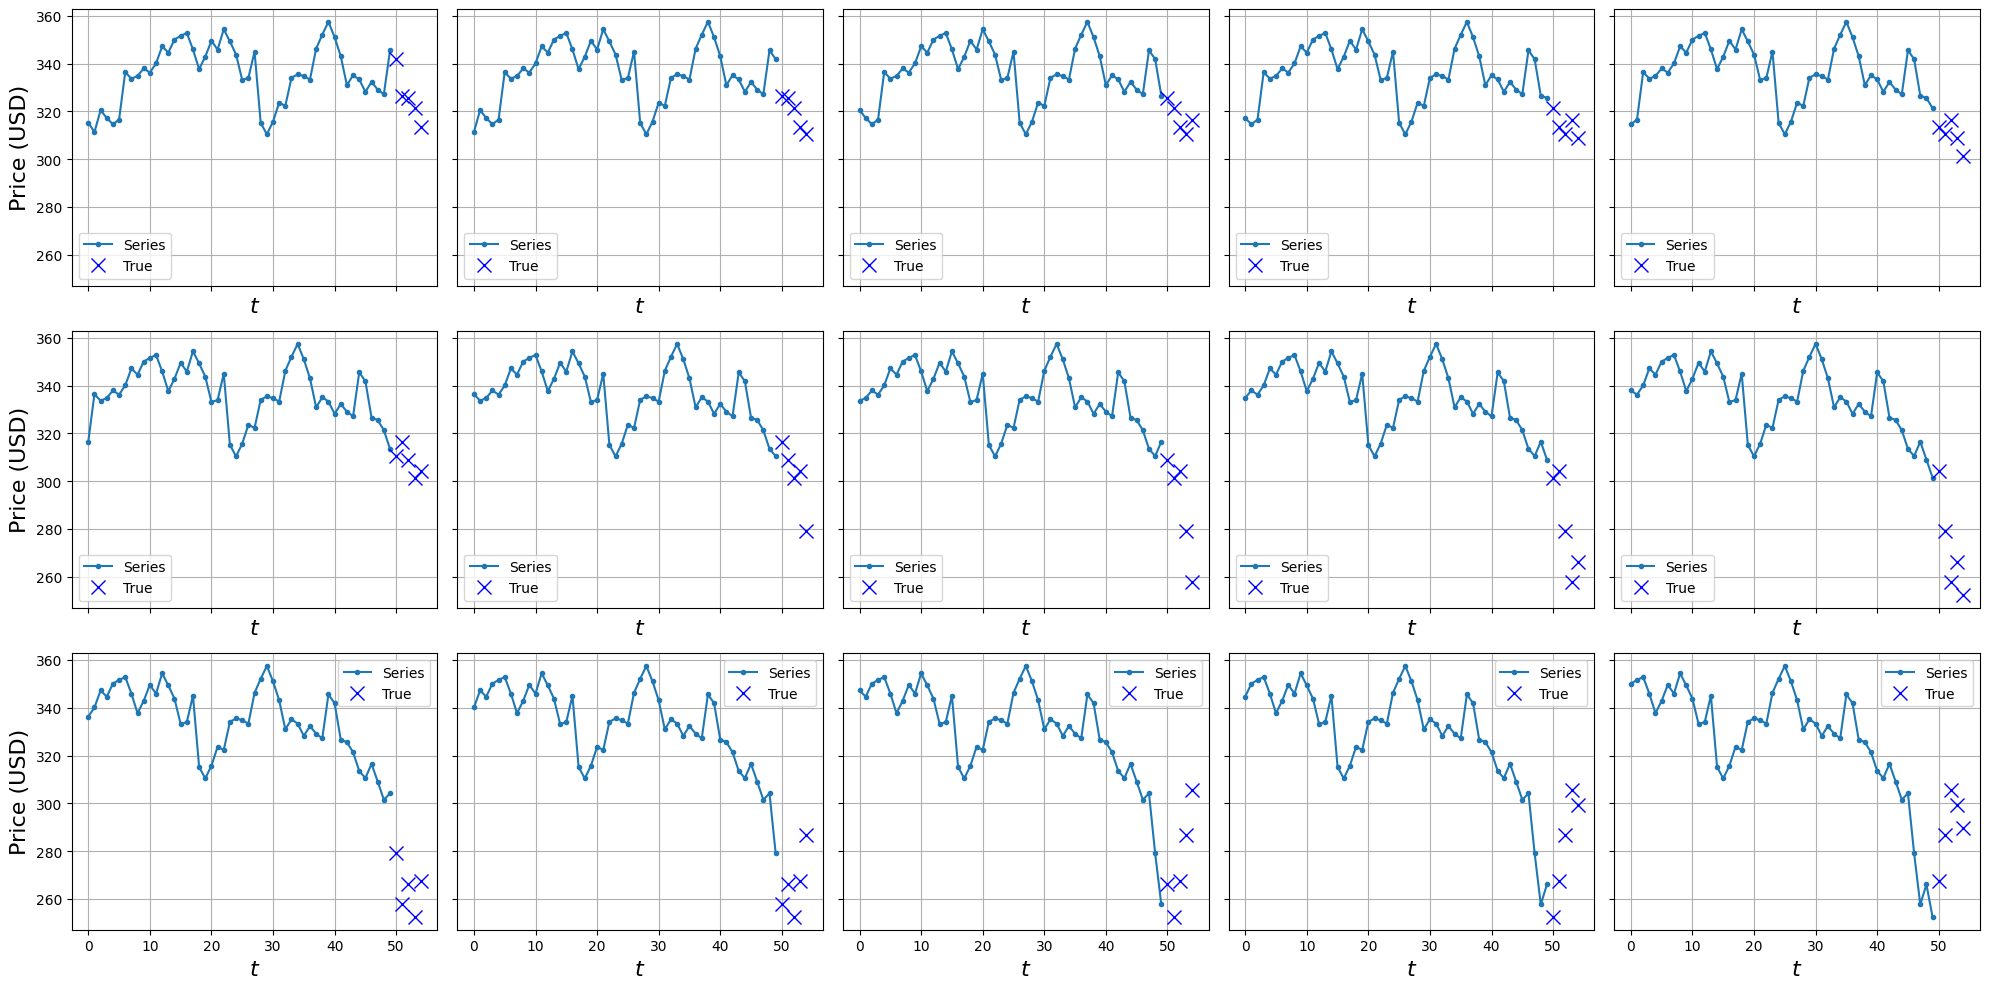

In [40]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="Price (USD)"):
    r, c = 3, 5
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = col + row * c
            if ix < len(series):
                series_unscaled = scaler.inverse_transform(series[ix].reshape(-1, 1)).flatten()
                plt.plot(series_unscaled, ".-", label="Series")
                if y is not None:
                    y_unscaled = scaler.inverse_transform(y[ix])
                    plt.plot(range(len(series_unscaled), len(series_unscaled)+len(y_unscaled)), y_unscaled, "bx", markersize=10, label="True")
                if y_pred is not None:
                    y_pred_unscaled = scaler.inverse_transform(y_pred[ix].reshape(1, -1)) # Reshape here
                    plt.plot(range(len(series_unscaled), len(series_unscaled)+len(y_pred_unscaled.flatten())), y_pred_unscaled.flatten(), "ro", label="Predicted") # Flatten for plotting
                plt.grid(True)
                plt.legend()
                plt.xlabel(x_label, fontsize=16)
                if col == 0:
                    plt.ylabel(y_label, fontsize=16, rotation=90)
    plt.tight_layout()
    plt.show()

plot_series(X_test[:15], y_test[:15])

Definir los modelos RNN, LSTM y GRU (adaptados para multi-step)

In [41]:
class RecurrentModel(nn.Module):
    def __init__(self, recurrent_type='RNN', input_size=1, hidden_size=40, output_size=5):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        if recurrent_type == 'RNN':
            self.recurrent = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        elif recurrent_type == 'LSTM':
            self.recurrent = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        elif recurrent_type == 'GRU':
            self.recurrent = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if isinstance(self.recurrent, nn.LSTM):
            out, (h, c) = self.recurrent(x)
        else:
            out, h = self.recurrent(x)
        y = self.fc(out[:, -1])
        return y

# Instanciar los modelos
models = {
    'RNN': RecurrentModel('RNN'),
    'LSTM': RecurrentModel('LSTM'),
    'GRU': RecurrentModel('GRU')
}

Función para entrenar un modelo

In [42]:
def fit(model, dataloader, epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_function = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in dataloader['train']:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(dataloader['train'].dataset)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.6f}')

    return model

# Entrenar todos los modelos
trained_models = {}
for name, model in models.items():
    print(f'Entrenando {name}...')
    trained_models[name] = fit(model, dataloader)

Entrenando RNN...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Train Loss = 0.021091
Epoch 10: Train Loss = 0.000209
Epoch 20: Train Loss = 0.000189
Epoch 30: Train Loss = 0.000235
Epoch 40: Train Loss = 0.000163
Entrenando LSTM...
Epoch 0: Train Loss = 0.028381
Epoch 10: Train Loss = 0.000294
Epoch 20: Train Loss = 0.000230
Epoch 30: Train Loss = 0.000209
Epoch 40: Train Loss = 0.000191
Entrenando GRU...
Epoch 0: Train Loss = 0.038545
Epoch 10: Train Loss = 0.000184
Epoch 20: Train Loss = 0.000171
Epoch 30: Train Loss = 0.000164
Epoch 40: Train Loss = 0.000156


Función para predecir y evaluar (adaptada para multi-step)

Resultados para RNN:
Test MSE (unscaled): 445.93 USD²
R² Score: 0.9062
MAPE: 4.74%
Porcentaje de acierto (±5% en todos los pasos): 34.46%
Resultados para LSTM:
Test MSE (unscaled): 513.44 USD²
R² Score: 0.8916
MAPE: 5.21%
Porcentaje de acierto (±5% en todos los pasos): 27.91%
Resultados para GRU:
Test MSE (unscaled): 448.44 USD²
R² Score: 0.9056
MAPE: 4.74%
Porcentaje de acierto (±5% en todos los pasos): 34.25%
El mejor modelo es RNN con MSE: 445.93


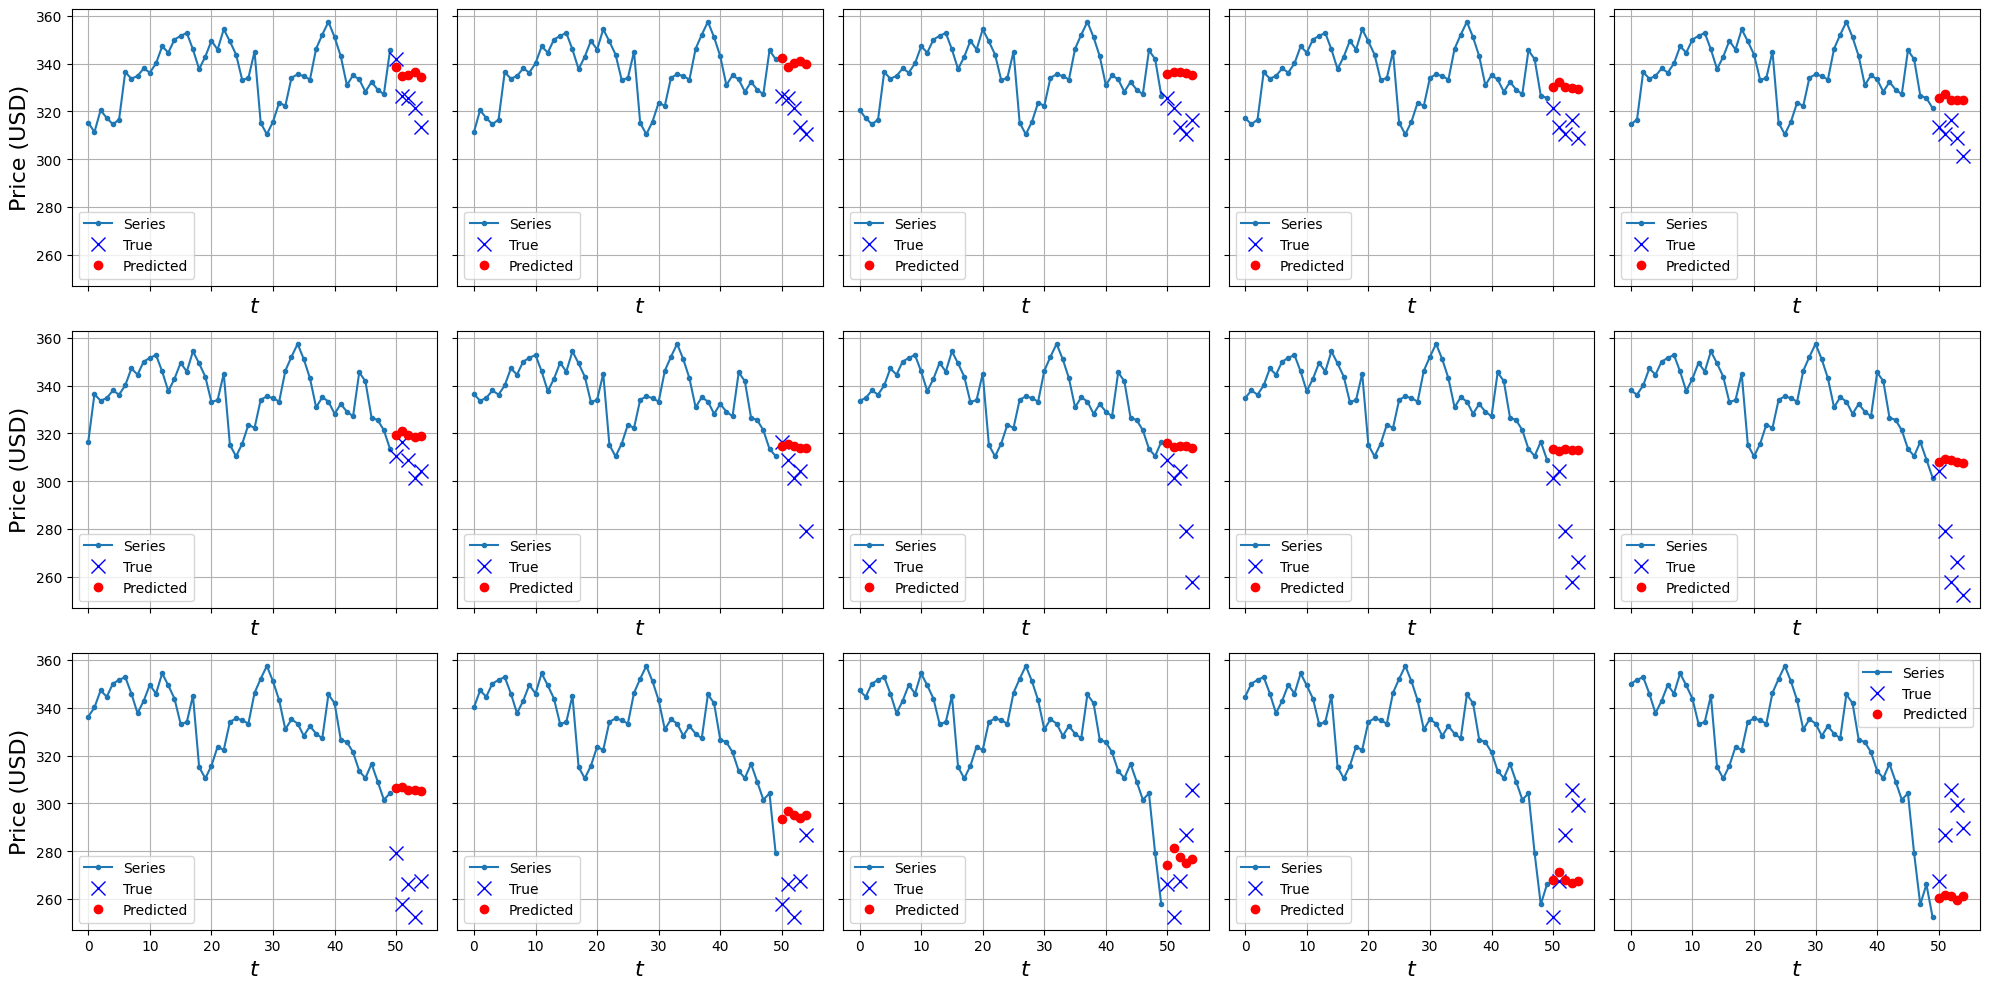

In [43]:
# Celda 6: Función para predecir y evaluar (adaptada para multi-step)
def predict(model, dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            predictions.append(y_pred.cpu().numpy())
    return np.concatenate(predictions, axis=0)

# Evaluar todos los modelos
results = {}
for name, model in trained_models.items():
    y_pred = predict(model, dataloader['test'])

    # Asegurar forma 2D para y_test y y_pred
    y_test_reshaped = y_test.numpy().reshape(-1, forecast_steps)
    y_pred_reshaped = y_pred.reshape(-1, forecast_steps)

    # Desescalar datos manteniendo forma 2D
    y_test_unscaled = scaler.inverse_transform(y_test_reshaped)
    y_pred_unscaled = scaler.inverse_transform(y_pred_reshaped)

    # Calcular métricas
    mse_unscaled = mean_squared_error(y_test_unscaled, y_pred_unscaled)
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)
    mape = np.mean(np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)) * 100

    # Porcentaje de acierto (±5% para todos los pasos predichos)
    tolerance = 0.05
    errors = np.abs((y_test_unscaled - y_pred_unscaled) / y_test_unscaled)
    accurate_predictions = np.all(errors <= tolerance, axis=1)
    accuracy_percentage = (np.sum(accurate_predictions) / len(accurate_predictions)) * 100

    results[name] = {
        'MSE': mse_unscaled,
        'R2': r2,
        'MAPE': mape,
        'Accuracy (%)': accuracy_percentage,
        'y_pred': y_pred
    }

    print(f'Resultados para {name}:')
    print(f'Test MSE (unscaled): {mse_unscaled:.2f} USD²')
    print(f'R² Score: {r2:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'Porcentaje de acierto (±5% en todos los pasos): {accuracy_percentage:.2f}%')

# Determinar el mejor modelo basado en MSE
best_model = min(results, key=lambda k: results[k]['MSE'])
print(f'El mejor modelo es {best_model} con MSE: {results[best_model]["MSE"]:.2f}')

# Graficar predicciones del mejor modelo
plot_series(X_test[:15], y_test[:15], results[best_model]['y_pred'][:15])

Predicciones futuras (5 días, multi-step)

In [44]:
def predict_future(model, last_sequence, num_predictions, scaler, device='cpu'):
    model.to(device)
    model.eval()
    predictions = []
    current_sequence = last_sequence.clone().detach().to(device)
    with torch.no_grad():
        for _ in range(num_predictions // forecast_steps + 1):
            y_pred = model(current_sequence.unsqueeze(0)).squeeze(0) # Remove the batch dimension
            # Reshape y_pred to be 2D before appending
            predictions.append(y_pred.cpu().numpy().reshape(-1, 1))
            # Ensure y_pred has the same last dimension as current_sequence for concatenation
            current_sequence = torch.cat((current_sequence[forecast_steps:], y_pred.unsqueeze(-1)), dim=0)
    predictions = np.concatenate(predictions)[:num_predictions]
    return scaler.inverse_transform(predictions)

# Predicciones futuras con el best model
last_sequence = X_test[-1]
future_predictions = predict_future(trained_models[best_model], last_sequence, num_predictions=5, scaler=scaler)
print('Predicciones futuras (5 días después del último dato) con el mejor modelo:')
for i, pred in enumerate(future_predictions):
    print(f'Día {i+1}: ${pred[0]:.2f}')

Predicciones futuras (5 días después del último dato) con el mejor modelo:
Día 1: $547.49
Día 2: $546.87
Día 3: $539.88
Día 4: $545.63
Día 5: $540.60
